In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure



In [3]:
X_train = pd.read_csv('../../datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Bikerental/y_test.csv',index_col=0)  
from sklearn.model_selection import train_test_split

# Specify the split ratio. For example, let's use 80% for training and 20% for validation
split_ratio = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split_ratio, random_state=42)


In [4]:
X_train_with_confounder=X_train.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
X_test_with_confounder=X_test.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
X_val_with_confounder=X_val.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])

In [6]:
X_train_with_confounder.columns

Index(['yr', 'temp', 'hum', 'windspeed', 'days_since_2011', 'holiday_HOLIDAY',
       'workingday_WORKING DAY', 'weathersit_GOOD', 'weathersit_MISTY',
       'weathersit_RAIN/SNOW/STORM'],
      dtype='object')

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_confounder)
X_test_scaled = scaler.transform(X_test_with_confounder)
X_val_scaled = scaler.transform(X_val_with_confounder)

In [8]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, hidden_layers, hidden_units, dropout, dropout_array, input_dim, output_dim, activation=nn.ReLU(),norm=False):
        if hidden_layers != len(hidden_units):
            print("Error: wrong size of hidden_layers or hidden_units")
            return
        layers = []
        i = 0
        if norm:
            layers.append(nn.BatchNorm1d(input_dim))

        super(Net, self).__init__()
        
        layers.append(nn.Linear(input_dim, hidden_units[i]))
        layers.append(activation)
        if dropout:
            layers.append(nn.Dropout(dropout_array[i]))

        for _ in range(hidden_layers - 1):
            i += 1
            layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))
            layers.append(activation)
            if dropout:
                layers.append(nn.Dropout(dropout_array[i]))

        layers.append(nn.Linear(hidden_units[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [9]:
config = {'batch_size': 8, 'lr': 0.00227297580848, 'num_epochs': 400, 'hidden_layers': 3, 'hidden_units': [32, 32, 128], 'dropout': False, 'dropout_array': [0.38283509966903684, 0.14655095633529086, 0.5393755103727268], 'activation': nn.ReLU(), 'norm': False}

input_dim = X_train_scaled.shape[1]
output_dim = 1

In [10]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
val_ds = TensorDataset(torch.Tensor(X_val_scaled), torch.Tensor(y_val.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [11]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [12]:
net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])

In [13]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
net = net.to(device)

In [14]:
summary(net,input_size=(10,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             352
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
              ReLU-4                   [-1, 32]               0
            Linear-5                  [-1, 128]           4,224
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [15]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [16]:
criterion = RMSELoss()
optimizer = optim.Adam(net.parameters(), lr=config["lr"])

In [17]:
def train_net(net, train_loader, criterion, optimizer, device):
    net.train()
    train_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader), net


def test_net(net, test_loader, criterion, device):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

    return test_loss / len(test_loader)


def train(config):
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"])
    net = Net(hidden_layers=config["hidden_layers"], hidden_units=config["hidden_units"], dropout=config["dropout"], dropout_array=config["dropout_array"], input_dim=input_dim, output_dim=output_dim, activation=config["activation"], norm=config["norm"])
    criterion = RMSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience = 10
    early_stop = False

    for epoch in range(config["num_epochs"]):
        train_loss,net = train_net(net, train_loader, criterion, optimizer, device)
        val_loss = test_net(net, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{config['num_epochs']}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 10
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping...")
                early_stop = True
                break

    if not early_stop:
        print("Training complete.")

    return train_losses, val_losses, net



In [18]:
train_losses, val_losses, mod = train(config)

Epoch [1/400], Train Loss: 4791.1229, Test Loss: 4906.0945
Epoch [2/400], Train Loss: 3707.0245, Test Loss: 1526.9097
Epoch [3/400], Train Loss: 1117.8491, Test Loss: 1029.9078
Epoch [4/400], Train Loss: 1006.4924, Test Loss: 1001.1049
Epoch [5/400], Train Loss: 986.6199, Test Loss: 957.2888
Epoch [6/400], Train Loss: 967.6329, Test Loss: 939.1415
Epoch [7/400], Train Loss: 943.8661, Test Loss: 923.1852
Epoch [8/400], Train Loss: 918.2208, Test Loss: 918.7825
Epoch [9/400], Train Loss: 928.2274, Test Loss: 916.6183
Epoch [10/400], Train Loss: 908.4524, Test Loss: 909.5140
Epoch [11/400], Train Loss: 910.7309, Test Loss: 907.8153
Epoch [12/400], Train Loss: 910.6822, Test Loss: 907.2132
Epoch [13/400], Train Loss: 905.8909, Test Loss: 895.7803
Epoch [14/400], Train Loss: 919.0991, Test Loss: 892.4403
Epoch [15/400], Train Loss: 886.5876, Test Loss: 915.7397
Epoch [16/400], Train Loss: 892.6205, Test Loss: 890.3385
Epoch [17/400], Train Loss: 886.1012, Test Loss: 906.9911
Epoch [18/400],

In [19]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

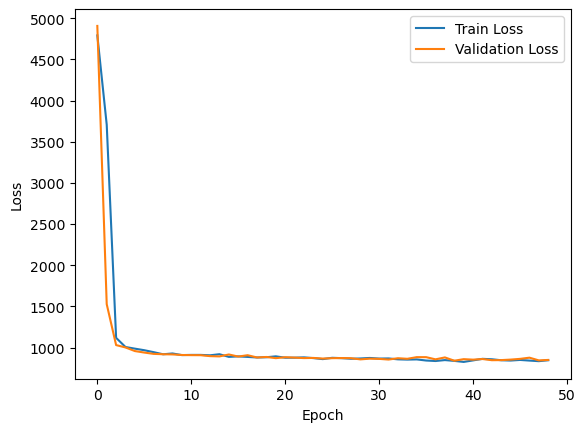

In [20]:
plot_losses(train_losses, val_losses)

In [21]:
def plot_predictions(net, data_loader, device):
    net.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


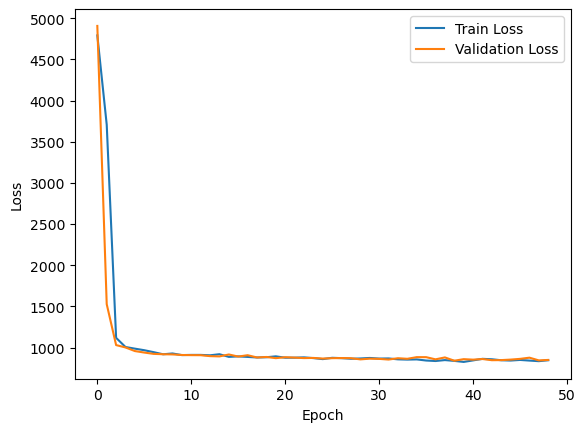

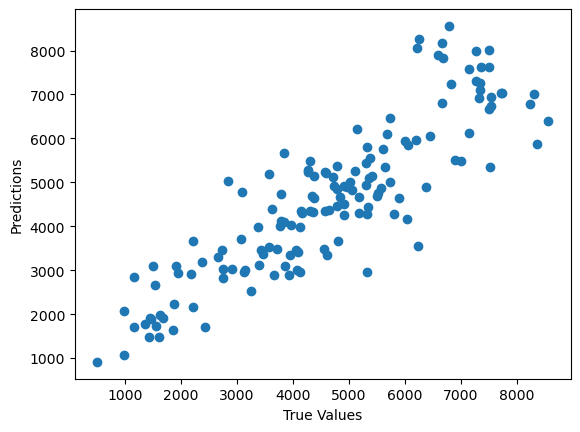

R^2 score: 0.7644173094964557
Train_loss: 885.5570068359375
Validation_loss: 914.38623046875
Test_loss: 921.345703125


C:\Users\Patrick\AppData\Local\Temp\ipykernel_2768\2864887404.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([y for _, y in test_ds])
C:\Users\Patrick\AppData\Local\Temp\ipykernel_2768\2864887404.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([y for _, y in test_ds])


In [22]:
#train_losses, test_losses = train(config)
plot_losses(train_losses, val_losses)
plot_predictions(mod, test_loader, device)
y_true = np.array([y for _, y in test_ds])
y_pred = mod(torch.Tensor(X_test_scaled).to(device)).cpu().detach().numpy()
r2 = r2_score(y_true, y_pred)
print("R^2 score:", r2)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_val_tensor = torch.Tensor(y_val.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
print("Train_loss:",criterion(mod(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item())
print("Validation_loss:",criterion(mod(torch.Tensor(X_val_scaled).to(device)),y_val_tensor).item())
print("Test_loss:",criterion(mod(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item())


In [24]:
torch.save(mod, '../../Models/bike_rental_model_confounder_76')

In [15]:

net = torch.load('./Models/bike_rental_model_confounder_2')
net.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)